# Litforge Library for LLaMA Model
This notebook demonstrates the implementation of a `Litforge` library that:
- Loads weights from a LLaMA model using Hugging Face (only for weight extraction).
- Implements the transformer forward pass and text generation using only PyTorch.
- Performs token-by-token generation using greedy decoding.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer

class LitForge(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.load_weights(model_name)

    def load_weights(self, model_name):
        # Loading the pretrained model using Transformers
        model = AutoModelForCausalLM.from_pretrained(model_name)
        self.weights = {k: v.clone().detach() for k, v in model.state_dict().items()}
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.config = model.config

    def forward(self, input_ids, past_key_values=None):
        # Mapping input IDs to embeddings
        x = self.weights["model.embed_tokens.weight"][input_ids]
        new_past = []
        for i in range(self.config.num_hidden_layers):
            q = F.linear(x, self.weights[f"model.layers.{i}.self_attn.q_proj.weight"])
            k = F.linear(x, self.weights[f"model.layers.{i}.self_attn.k_proj.weight"])
            v = F.linear(x, self.weights[f"model.layers.{i}.self_attn.v_proj.weight"])
            if past_key_values is not None:
                past_k, past_v = past_key_values[i]
                k = torch.cat([past_k, k], dim=1)
                v = torch.cat([past_v, v], dim=1)
            new_past.append((k, v))
            # Scaled dot-product attention
            scale = self.config.hidden_size ** 0.5
            attn_scores = torch.matmul(q, k.transpose(-2, -1)) / scale
            attn_probs = F.softmax(attn_scores, dim=-1)
            attn_out = torch.matmul(attn_probs, v)
            # Output projection with residual connection
            proj = F.linear(attn_out, self.weights[f"model.layers.{i}.self_attn.o_proj.weight"])
            x = x + proj
            # Feed-forward network with GELU activation and residual connection
            ff = F.linear(x, self.weights[f"model.layers.{i}.mlp.fc_in.weight"],
                           self.weights.get(f"model.layers.{i}.mlp.fc_in.bias", None))
            ff = F.gelu(ff)
            ff = F.linear(ff, self.weights[f"model.layers.{i}.mlp.fc_out.weight"],
                           self.weights.get(f"model.layers.{i}.mlp.fc_out.bias", None))
            x = x + ff
        # Layer normalization and weight tying to compute final logits
        x = F.layer_norm(x, (self.config.hidden_size,),
                         weight=self.weights["model.norm.weight"],
                         bias=self.weights["model.norm.bias"])
        logits = torch.matmul(x, self.weights["model.embed_tokens.weight"].T)
        return logits, new_past

    def generate(self, prompt, max_length=512):
        # Tokenizing the prompt and generate text via greedy decoding
        input_ids = torch.tensor([self.tokenizer.encode(prompt)], dtype=torch.long)
        self.eval()
        with torch.no_grad():
            logits, past = self.forward(input_ids, None)
            for _ in range(max_length - input_ids.shape[1]):
                last_token = input_ids[:, -1:]
                logits, past = self.forward(last_token, past_key_values=past)
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)
                if next_token.item() == self.tokenizer.eos_token_id:
                    break
        return self.tokenizer.decode(input_ids[0].tolist())


In [2]:

!pip install transformers


In [3]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineG

## Model Demonstration: Visualizing Weights and Generating Text

This cell will:
1. Load the model (using `"meta-llama/Llama-3.2-1B"` as an example for demonstration).
2. Print key weight shapes and configuration details.
3. Visualize the distribution of embedding weights using a histogram.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model Configuration:
LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.48.3",
  "use_cache": true,
  "vocab_size": 128256
}


Embedding weight shape: torch.Size([12825

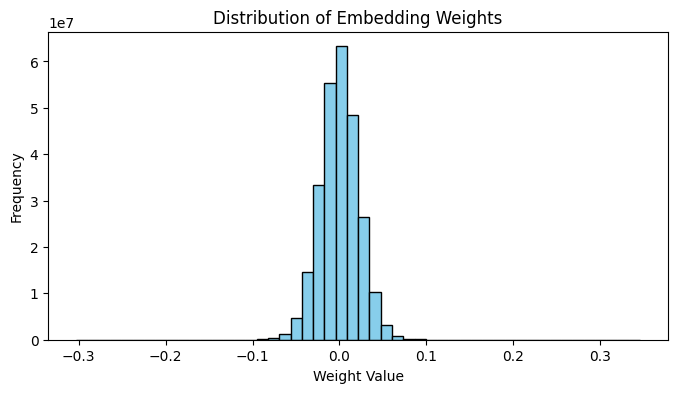

In [6]:
import matplotlib.pyplot as plt

model_name = "meta-llama/Llama-3.2-1B"
model = LitForge(model_name)

print("Model Configuration:")
print(model.config)

print("\nEmbedding weight shape:", model.weights["model.embed_tokens.weight"].shape)
print("Layer 0 q_proj weight shape:", model.weights["model.layers.0.self_attn.q_proj.weight"].shape)

weights = model.weights["model.embed_tokens.weight"].cpu().numpy().flatten()
plt.figure(figsize=(8, 4))
plt.hist(weights, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Embedding Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()